# M5 Competiotn - Data Exploratory 

 

The first step in each data science is to explore the data 
The kernel is my interpretation trying to do some exploratory data 
Some idea and code for this notebook were taken from :
https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration 

Since the data contains a lot of time series I tried to use the ipywidgets package 
The idea is that you can select and slice the data and based on that see more data 
Unfortunately, Kaggle only support this kind of widgets on the on-line kerenl, 
after committing the kernel lose the widgets' functionality - Hopefully this will be solved soon 

What next : 
* add some more data exploratory 
* write some conclusions 
* Create some models for predictions  

## If you like it please upvote 

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
import random 
from itertools import cycle
from ipywidgets import widgets, interactive
from tqdm.autonotebook import tqdm
import datetime
import seaborn as sns


tqdm.pandas()
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

# File 1: “calendar.csv” 
Contains information about the dates the products are sold.
* date: The date in a “y-m-d” format.
* wm_yr_wk: The id of the week the date belongs to.
* weekday: The type of the day (Saturday, Sunday, …, Friday).
* wday: The id of the weekday, starting from Saturday.
* month: The month of the date.
* year: The year of the date.
* event_name_1: If the date includes an event, the name of this event.
* event_type_1: If the date includes an event, the type of this event.
* event_name_2: If the date includes a second event, the name of this event.
* event_type_2: If the date includes a second event, the type of this event.
* snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP  purchases on the examined date. 1 indicates that SNAP purchases are allowed.


In [ ]:
df_calendar = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
df_calendar.head()

In [ ]:
df_calendar.shape

# M5 Competition  - DataSet 
The Diagram below illustrates the hierarchial data structure: 
* 3 States 
* 10 Stores 
* 3 categories 
* 3049 unique items 


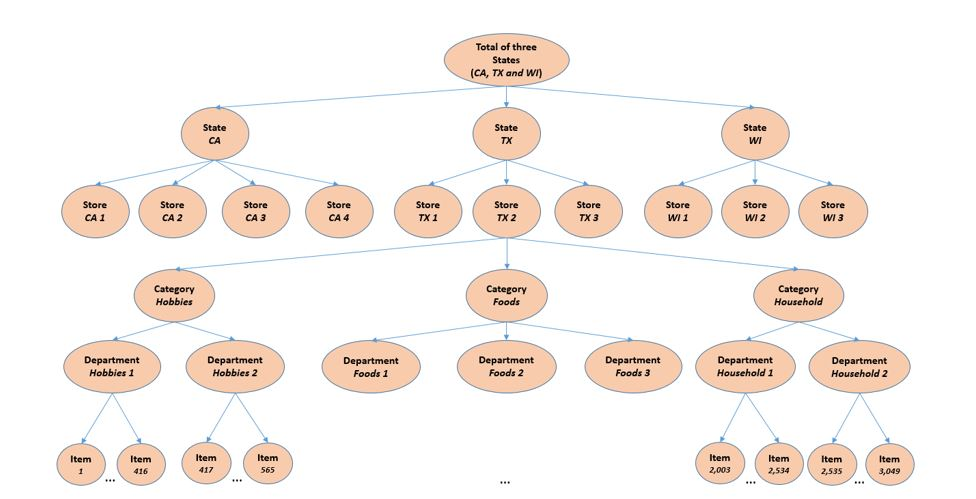

# File 2: “sell_prices.csv”
Contains information about the price of the products sold per store and date.
* store_id: The id of the store where the product is sold. 
* item_id: The id of the product.
* wm_yr_wk: The id of the week.
* sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).  


In [ ]:
df_sell_prices = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')
df_sell_prices.head()

In [ ]:
df_sell_prices.shape

In [ ]:
print ("Tehere are:", len(df_sell_prices['item_id'].unique()) , "unique items")

In [ ]:
print ("Tehere are:", len(df_sell_prices['store_id'].unique()) , "unique stores")

In [ ]:
print ("maximuim all items price is :",max(df_sell_prices['sell_price']),"$")
print ("minimum all items price is :",min(df_sell_prices['sell_price']),"$")
print ("average all item price is :",round(sum(df_sell_prices['sell_price'])/len(df_sell_prices['sell_price']),2),"$")

# File 3: “sales_train.csv” 
Contains the historical daily unit sales data per product and store.
* item_id: The id of the product.
* dept_id: The id of the department the product belongs to.
* cat_id: The id of the category the product belongs to.
* store_id: The id of the store where the product is sold.
* state_id: The State where the store is located.
* d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29. 


In [ ]:
df_sales_train = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')
df_sales_train.head()

In [ ]:
df_sales_train[df_sales_train['store_id']=='TX_1'].head()

In [ ]:
df_sales_train.shape

# Visualization 
1. Convert the dates from the calendar  data from strings to dates.
2. Plot bars of items per categories and per Department.
3. Use Transpose to move the unit sales data per day into rows.

# Items Per Categories 

In [ ]:

ax = df_sales_train.groupby(['cat_id'])['item_id'].describe()['unique'].plot(kind='bar',
                                    figsize=(14,4),
                                    color=['r', 'g', 'b', 'r', 'g', 'b', 'r'])

ax.set_title("Items Per Categories", fontsize= 18)
plt.xticks(rotation=45)
ax.set_ylabel("Number Of Items",fontsize = 14)
ax.set_xlabel("Category",fontsize=14)
plt.show()

# Items Per Department 

In [ ]:

ax = df_sales_train.groupby(['dept_id'])['item_id'].describe()['unique'].plot(kind='bar',
                                    figsize=(14,4),
                                    color=['r', 'g', 'b', 'r', 'g', 'b', 'r'])

ax.set_title("Items Per Department ", fontsize= 18)
plt.xticks(rotation=45)
ax.set_ylabel("Number Of Items",fontsize = 14)
ax.set_xlabel("Department",fontsize=14)
plt.show()

In [ ]:
#Create date index
date_index = df_calendar['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [ ]:
# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
df_sales_train['item_store_id'] = df_sales_train.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = df_sales_train.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = df_sales_train['item_store_id'].values

#Set Dates as index 
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)

DF_Sales.head()

# Time Series - One Selection
  

In [ ]:
index = 17005
#y = df_sales_train.loc[index,'d_1':'d_1913'].T
y = pd.DataFrame(DF_Sales.iloc[:,index])
y = pd.DataFrame(y).set_index([dates_list])
y.index = pd.to_datetime(y.index)

ax = y.plot(figsize=(18, 5),color='black')
ax.set_facecolor('lightgrey')
plt.show()

 

# Time Series - By Department 
 

In [ ]:


# Make a dropdown to select the Department
Department = widgets.Dropdown(
    options= list(df_sales_train['dept_id'].unique()),
    value='FOODS_1',
    style = {'description_width': 'initial'},
    description='Select Department:', 
   
      
    
)




#Plot some examples from the selected category 
def Plot_Rand_TS_From_Department(Department,Seed = 43):
    col_index = DF_Sales.columns[DF_Sales.columns.str.contains(pat = Department)]
    random.seed(Seed)
    examples_index = random.sample(list(col_index),24)
    ts_sample = DF_Sales[examples_index]




    fig, axs = plt.subplots(8, 3, figsize=(18, 22))
    axs = axs.flatten()
    ax_idx = 0
    for item in ts_sample.columns:
        ax = ts_sample[item].plot(title=item,
                                  fontsize = 14,
                                  color=next(color_cycle),
                                  ax=axs[ax_idx])
        ax.set_xlabel("Date",size=15)
        ax.set_ylabel("Item Sold",size = 15)
        ax_idx += 1
    plt.tight_layout()
    plt.show()


out = interactive(Plot_Rand_TS_From_Department,Department = Department,Seed = 43)
out 

# Time Series - Same item in different stores 


Notes : 
* If an item out of the items range is selected - item 001 will be presented
* Seed changes will change the selection 

In [ ]:
#Plot some examples from specific category across all stores 



# Make a dropdown to select the Department
Department = widgets.Dropdown(
    options= list(df_sales_train['dept_id'].unique()),
    value='FOODS_1',
    style = {'description_width': 'initial'},
    description='Select Department:', 
 
)

# Make a dropdown to select the item
item = widgets.BoundedFloatText(
    #department = Department.observe(on_value_change, names='value'),
    #minmax = Calc_Min_Max_Item(department = Department.observe(on_value_change, names='value')),
    value=55,
    min=0,
    max=1000,
    style = {'description_width': 'initial'},
    step=1,
    description='Item Numberr:',
    disabled=False,
    color='black'
)


def Plot_TS_Items_Across_Stores(Department,Item) : 
    Item = int(Item)
    if Item < 10:
        ItemS = '00'+str(Item)
    if Item >9 and Item < 100:
         ItemS = '0'+str(Item)
    if Item > 99 :
        ItemS = str(Item)
    if Item == None:
        ItemS = '001'
    select_item =str(Department)+'_'+str(ItemS)
     
    examples_index = DF_Sales.columns[DF_Sales.columns.str.contains(pat = select_item)]
    
    if len(examples_index) ==0 : 
        select_item =str(Department)+'_'+str('001')
        examples_index = DF_Sales.columns[DF_Sales.columns.str.contains(pat = select_item)]
            
    ts_sample = DF_Sales[examples_index]


    fig, axs = plt.subplots(5, 2, figsize=(15, 10))
    axs = axs.flatten()
    ax_idx = 0
    for item in ts_sample.columns:
        ax = ts_sample[item].plot(title=item,
                                  fontsize = 14,
                                  color=next(color_cycle),
                                  ax=axs[ax_idx])
        ax_idx += 1
        ax.set_xlabel("Date",size=15)
        ax.set_ylabel("Item Sold",size = 15)
    plt.tight_layout()
    plt.show()
    

interactive(Plot_TS_Items_Across_Stores,Department = Department,Item = item)

# Aggregation 


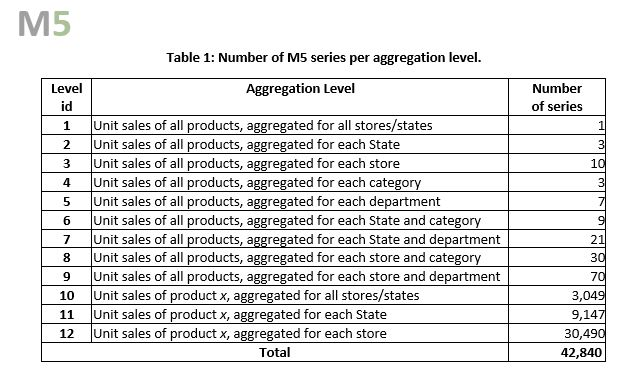


# Aggregiation  Level 11 & 10 
* Unit sales of product x, aggregated for all stores/states
* Unit sales of product x, aggregated for each State


In [ ]:
 

# Make a dropdown to select the Department
Department = widgets.Dropdown(
    options= list(df_sales_train['dept_id'].unique()),
    value='FOODS_1',
    style = {'description_width': 'initial'},
    description='Select Department:', 
 
)

# Make a dropdown to select the item
item = widgets.BoundedFloatText(
    #department = Department.observe(on_value_change, names='value'),
    #minmax = Calc_Min_Max_Item(department = Department.observe(on_value_change, names='value')),
    value=55,
    min=0,
    max=1000,
    style = {'description_width': 'initial'},
    step=1,
    description='Item Numberr:',
    disabled=False,
    color='black'
)



def Plot_TS_Items_Aggr_Stata_All(Department,Item) : 

     
    Item = int(Item)
    if Item < 10:
        ItemS = '00'+str(Item)
    if Item >9 and Item < 100:
         ItemS = '0'+str(Item)
    if Item > 99 :
        ItemS = str(Item)
    if Item == None:
        ItemS = '001'
    Product =str(Department)+'_'+str(ItemS)
    
         
    
    df_product = DF_Sales.copy(deep=True)
    df_product =  df_product[df_product.columns[df_product.columns.str.contains(pat = Product)]]
    states = ['CA','TX','WI','All']
    
    
    if df_product.shape[1] == 0:
        Product =str(Department)+'_'+str('001')
        df_product =  DF_Sales[DF_Sales.columns[DF_Sales.columns.str.contains(pat = Product)]]
        

    #Aggregate All 
    df_product.loc[:,'All'] = df_product.apply(lambda x:sum(x),axis=1)

    #Aggregate across states 
    df_product.loc[:,'CA'] = df_product[df_product.columns[df_product.columns.str.contains(pat = 'CA')]].apply\
        (lambda x:sum(x),axis=1)
    df_product.loc[:,'TX'] = df_product[df_product.columns[df_product.columns.str.contains(pat = 'TX')]].apply\
        (lambda x:sum(x),axis=1)
    df_product.loc[:,'WI'] = df_product[df_product.columns[df_product.columns.str.contains(pat = 'WI')]].apply\
        (lambda x:sum(x),axis=1)



    #fig, axs = plt.subplots(1, 1, figsize=(15, 10))
    fig, axs = plt.subplots(2, 2, figsize=(14, 6))
    axs = axs.flatten()

    ax_idx = 0

    for state in states:
        ax = df_product[state].plot(title=Product+' '+state,
                                      fontsize = 14,
                                      color=next(color_cycle),
                                      ax=axs[ax_idx])
        ax_idx += 1
        ax.set_xlabel("Date",size=15)
        ax.set_ylabel("Item Sold",size = 15)
    plt.tight_layout()
    plt.show()


interactive(Plot_TS_Items_Aggr_Stata_All,Department = Department,Item = item)
 

# Aggregiation  Level 9
* Unit sales of all products, aggregated for each store and department


In [ ]:


# Make a dropdown to select the Department
Department = widgets.Dropdown(
    options= list(df_sales_train['dept_id'].unique()),
    value='FOODS_1',
    style = {'description_width': 'initial'},
    description='Select Department:', 
 
)


def Plot_Department_Agg_By_Sate(Department):
    df_department = DF_Sales.copy(deep = True)
     
    #Create Store List 
    Stores = pd.Series(df_department.columns).apply(lambda x: x[-4:]).unique()
    df_department =  df_department[DF_Sales.columns[df_department.columns.str.contains(pat = Department)]]
    for store in Stores :
        df_department.loc[:,store] = df_department[df_department.columns[df_department.columns.str.contains(pat = store)]].apply\
            (lambda x:sum(x),axis=1)


    fig, axs = plt.subplots(5, 2, figsize=(14, 12))
    axs = axs.flatten()

    ax_idx = 0

    for store in Stores:
            ax = df_department[store].plot(title=Department+' '+store,
                                          fontsize = 14,
                                          color=next(color_cycle),
                                          #ax = axs.get_subplotspec().rowspan.start
                                          ax=axs[ax_idx])
            ax_idx += 1
            ax.set_xlabel("Date",size=15)
            ax.set_ylabel("Item Sold",size = 15)
    plt.tight_layout()
    plt.show()
    
    
interactive(Plot_Department_Agg_By_Sate,Department = Department)

# Aggregiation  Level 8
* Unit sales of all products, aggregated for each store and category


In [ ]:


# Make a dropdown to select the Department
Category = widgets.Dropdown(
    options= list(df_sales_train['cat_id'].unique()),
    value='FOODS',
    style = {'description_width': 'initial'},
    description='Select Department:', 
 
)


def Plot_Category_Agg_By_Sate(Category):
    df_Category = DF_Sales.copy(deep = True)
     
    #Create Store List 
    Stores = pd.Series(df_Category.columns).apply(lambda x: x[-4:]).unique()
    df_Category =  df_Category[df_Category.columns[df_Category.columns.str.contains(pat = Category)]]
    for store in Stores :
        df_Category.loc[:,store] = df_Category[df_Category.columns[df_Category.columns.str.contains(pat = store)]].apply\
            (lambda x:sum(x),axis=1)


    fig, axs = plt.subplots(5, 2, figsize=(14, 12))
    axs = axs.flatten()

    ax_idx = 0

    for store in Stores:
            ax = df_Category[store].plot(title=Category+' '+store,
                                          fontsize = 14,
                                          color=next(color_cycle),
                                          ax=axs[ax_idx])
            ax_idx += 1
            ax.set_xlabel("Date",size=15)
            ax.set_ylabel("Item Sold",size = 15)
    plt.tight_layout()
    plt.show()
    
    
interactive(Plot_Category_Agg_By_Sate,Category = Category)

# Aggregiation  Level 7
* Unit sales of all products, aggregated for each State and department


In [ ]:

df_Department = DF_Sales.copy(deep = True)
     
#Create Store List 
States = ['CA','TX','WI']
Departmants = pd.Series(df_Department.columns).apply(lambda x: x[:-9]).unique()


#Create date index
date_index = df_calendar['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]
df = df_sales_train.groupby(['dept_id','state_id'])[df_sales_train.filter(regex='d_.*').columns].sum()
df = df.reset_index()


fig, axs = plt.subplots(7, 3, figsize=(14, 16))
axs = axs.flatten()

ax_idx = 0

for index, row in df.iterrows():
    y = pd.DataFrame(row['d_1':'d_1913']).set_index([dates_list])
    y.index = pd.to_datetime(y.index)
     
    
    ax = y.plot(title=row.dept_id+' '+row.state_id,
                                          fontsize = 14,
                                          color=next(color_cycle),
                                        ax=axs[ax_idx])
     
    ax_idx += 1
    ax.set_xlabel("Date",size=15)
    ax.set_ylabel("Item Sold",size = 15)
     
     
plt.tight_layout()
plt.show()


# Aggregiation  Level 6
* Unit sales of all products, aggregated for each State and category

In [ ]:
#Create date index
date_index = df_calendar['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]
df = df_sales_train.groupby(['cat_id','state_id'])[df_sales_train.filter(regex='d_.*').columns].sum()
df = df.reset_index()


fig, axs = plt.subplots(3, 3, figsize=(14, 16))
axs = axs.flatten()

ax_idx = 0

for index, row in df.iterrows():
    y = pd.DataFrame(row['d_1':'d_1913']).set_index([dates_list])
    y.index = pd.to_datetime(y.index)
     
    
    ax = y.plot(title=row.cat_id+' '+row.state_id,
                                          fontsize = 14,
                                          color=next(color_cycle),
                                        ax=axs[ax_idx])
     
    ax_idx += 1
    ax.set_xlabel("Date",size=15)
    ax.set_ylabel("Item Sold",size = 15)
     
     
plt.tight_layout()
plt.show()

# Aggregiation  Level 5
* Unit sales of all products, aggregated for each department

In [ ]:
#Create date index
date_index = df_calendar['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]
df = df_sales_train.groupby(['dept_id'])[df_sales_train.filter(regex='d_.*').columns].sum()
df = df.reset_index()


fig, axs = plt.subplots(4, 2, figsize=(14, 16))
axs = axs.flatten()

ax_idx = 0

for index, row in df.iterrows():
    y = pd.DataFrame(row['d_1':'d_1913']).set_index([dates_list])
    y.index = pd.to_datetime(y.index)
     
    
    ax = y.plot(title=row.dept_id,
                                          fontsize = 14,
                                          color=next(color_cycle),
                                        ax=axs[ax_idx])
     
    ax_idx += 1
    ax.set_xlabel("Date",size=15)
    ax.set_ylabel("Item Sold",size = 15)
     
     
plt.tight_layout()
plt.show()

# Item Prices 

In [ ]:
df_calendar.shape

In [ ]:
#%%time
# Add date column to sales price (use the calndat data)
df_calendar_weeks = df_calendar[df_calendar['weekday']=='Monday']
df_calendar_weeks = df_calendar[['date','wm_yr_wk']]
(df_sell_prices['wm_yr_wk'].unique())
calendar_index = df_calendar_weeks.drop_duplicates(subset='wm_yr_wk').reset_index(drop=True)

df_sell_prices_dates = df_sell_prices.merge(calendar_index,on='wm_yr_wk',how='outer')


In [ ]:
#combine item id and store id 
df_sell_prices_dates['item_store_id'] = df_sell_prices_dates.progress_apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)

In [ ]:
# Make a dropdown to select the Department
Department = widgets.Dropdown(
    options= list(df_sales_train['dept_id'].unique()),
    value='FOODS_1',
    style = {'description_width': 'initial'},
    description='Select Department:', 
   
      
    
)

#Plot some price examples from the selected category 
def Plot_Rand_TS_From_Department(Department,Seed = 43):
    df = df_sell_prices_dates[df_sell_prices_dates.item_store_id.str.contains(pat = Department)]
    item_stores_list = df['item_store_id'].unique()
    item_stores_list
    examples_items = random.sample(list(item_stores_list),20)
    ts_samples = pd.DataFrame()

    fig, axs = plt.subplots(10, 2, figsize=(18, 24))
    axs = axs.flatten()
    
    ax_idx = 0

    for item in examples_items:
        ts_samples = df[df.item_store_id.str.contains(pat = item)]
        ts_samples = ts_samples.set_index(ts_samples['date'])
        ax = ts_samples['sell_price'].plot(title=item,
                                      fontsize = 14,
                                      color=next(color_cycle),
                                      ax=axs[ax_idx])
       
        ax.set_xlabel("Date",size=14)
        ax.set_ylabel("Price (in US$)",size = 15)
        ax_idx += 1
    plt.tight_layout()
    plt.show()


interactive(Plot_Rand_TS_From_Department,Department = Department,Seed = 43)



# Correlation 

In [ ]:

# Make a dropdown to select the Department
Department = widgets.Dropdown(
    options= list(df_sales_train['dept_id'].unique()),
    value='FOODS_1',
    style = {'description_width': 'initial'},
    description='Select Department:', 
     
    
)


# Make a dropdown to select the Department
Store = widgets.Dropdown(
    options= list(df_sales_train['store_id'].unique()),
    value='CA_1',
    style = {'description_width': 'initial'},
    description='Select Store:', 
     
    
)

def Calc_Corr(Department,Store):

    df_department = DF_Sales.copy(deep = True)
    df_department =  df_department[df_department.columns[df_department.columns.str.contains(pat = Department)]]
    df_department =  df_department[df_department.columns[df_department.columns.str.contains(pat = Store)]]

    #Calculate the top Corrlated TS
    corr_matrix = df_department.corr().abs()
    #the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
    sol = pd.DataFrame(corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                     .stack()
                     .sort_values(ascending=False)).reset_index()

    Top_TS = np.concatenate([sol.iloc[0:10]['level_0'].unique(),sol.iloc[0:10]['level_1'].unique()])

    df_department_top_corr = df_department[Top_TS]




    corr = df_department_top_corr.corr()
    matrix = np.triu(df_department_top_corr.corr())
    plt.figure(figsize=(15,13))
    # plot the heatmap


    sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',mask=matrix,cbar=False,
            xticklabels=corr.columns,
            yticklabels=corr.columns)
    plt.xticks(rotation=45) 
    print(sol.head(10))
    
interactive(Calc_Corr,Department = Department,Store = Store)
